Loading datasets and building vocabulary...
Vocabulary built with 9188 unique words.
Sample of 1500 rows taken from validation set.


c:\Users\chira\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Testing Thresholds:   0%|          | 0/10 [00:00<?, ?it/s]


Running test for MAX_EDIT_DISTANCE = 1...

Running test for MAX_EDIT_DISTANCE = 2...

Running test for MAX_EDIT_DISTANCE = 3...

Running test for MAX_EDIT_DISTANCE = 4...

Running test for MAX_EDIT_DISTANCE = 5...

Running test for MAX_EDIT_DISTANCE = 6...

Running test for MAX_EDIT_DISTANCE = 7...

Running test for MAX_EDIT_DISTANCE = 8...

Running test for MAX_EDIT_DISTANCE = 9...

Running test for MAX_EDIT_DISTANCE = 10...

--- Test Results ---
   Threshold  Sentence Accuracy  Word Accuracy  Noun Accuracy       CER
0          1           4.666667      68.377941      73.393060  3.552430
1          2           7.066667      68.602285      73.833902  4.002202
2          3           7.400000      68.482287      73.321957  4.734246
3          4           7.666667      68.440549      73.250853  5.126634
4          5           7.733333      68.404028      73.051763  5.315849
5          6           7.666667      68.383159      72.994881  5.403477
6          7           7.666667      68.367

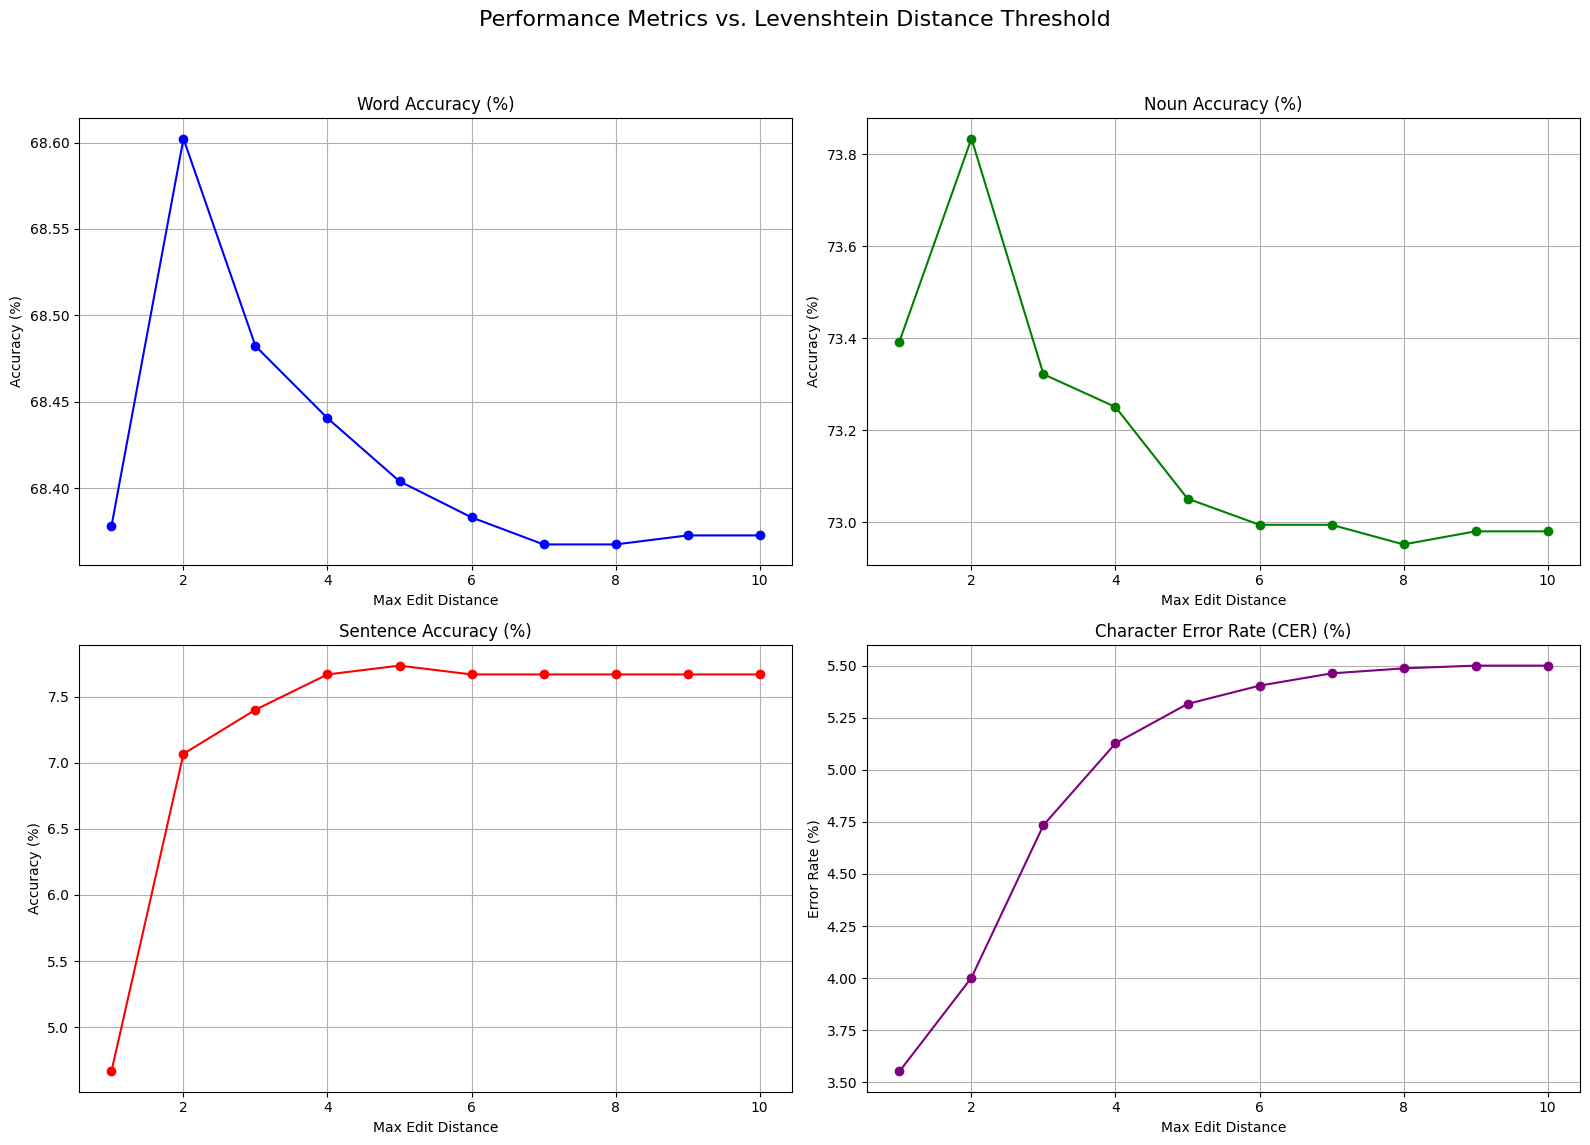

In [1]:
import pandas as pd
import numpy as np
import ast
import spacy
from nltk.metrics.distance import edit_distance
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- 1. Load Data and Build Vocabulary ---
print("Loading datasets and building vocabulary...")
try:
    # Load datasets [cite: 893, 895]
    train_df = pd.read_csv('../dataset/train.csv')
    val_df = pd.read_csv('../dataset/validation.csv')

    # Build vocabulary from training data [cite: 905, 906]
    all_correct_words = ' '.join(train_df['correct_cleaned_baseline'].astype(str)).split()
    vocabulary = set(all_correct_words)
    print(f"Vocabulary built with {len(vocabulary)} unique words.")

    # Safely convert 'target_nouns' from string back to a list [cite: 897, 898]
    val_df['target_nouns'] = val_df['target_nouns'].apply(ast.literal_eval)

    # Take the first 1500 rows for the test
    val_sample_df = val_df.head(1500).copy()
    print(f"Sample of {len(val_sample_df)} rows taken from validation set.")

except FileNotFoundError:
    print("Error: Make sure 'train.csv' and 'validation.csv' are in the '../dataset/' directory.")
    # Create empty dataframes to prevent further errors
    val_sample_df = pd.DataFrame()
    vocabulary = set()

# Load spacy model for noun extraction [cite: 891]
nlp = spacy.load("en_core_web_sm")

# --- 2. Adapt Correction and Evaluation Functions from the Notebooks ---

# Modified Levenshtein correction functions to accept a distance threshold [cite: 916, 934]
def get_levenshtein_correction(word, vocab, max_dist):
    """Finds the best correction based on Levenshtein distance within a threshold."""
    if word in vocab:
        return word
    
    suggestions = [(edit_distance(word, v_word), v_word) for v_word in vocab if abs(len(word) - len(v_word)) <= max_dist]
    
    if not suggestions:
        return word
        
    best_suggestion = min(suggestions, key=lambda x: x[0])
    
    # Use suggestion only if it's within the specified threshold
    if best_suggestion[0] <= max_dist:
        return best_suggestion[1]
    else:
        return word

def baseline_sentence_correction(sentence, vocab, max_dist):
    """Applies Levenshtein correction to an entire sentence with a given threshold."""
    words = str(sentence).split()
    corrected_words = [get_levenshtein_correction(word, vocab, max_dist) for word in words]
    return ' '.join(corrected_words)

# Evaluation metric functions from the notebook [cite: 1042, 1045, 1057, 1068]
def calculate_sentence_accuracy(df, true_col, pred_col):
    correct_sentences = (df[true_col] == df[pred_col]).sum()
    return (correct_sentences / len(df)) * 100

def calculate_word_accuracy(df, true_col, pred_col):
    total_words, correct_words = 0, 0
    for _, row in df.iterrows():
        true_words = str(row[true_col]).split()
        pred_words = str(row[pred_col]).split()
        total_words += len(true_words)
        for i in range(min(len(true_words), len(pred_words))):
            if true_words[i] == pred_words[i]:
                correct_words += 1
    return (correct_words / total_words) * 100 if total_words > 0 else 0

def calculate_cer(df, true_col, pred_col):
    total_distance, total_chars = 0, 0
    for _, row in df.iterrows():
        true_sent = str(row[true_col])
        pred_sent = str(row[pred_col])
        total_distance += edit_distance(true_sent, pred_sent)
        total_chars += len(true_sent)
    return (total_distance / total_chars) * 100 if total_chars > 0 else 0

def calculate_noun_accuracy(df, true_nouns_col, pred_sent_col):
    total_true_nouns, correctly_predicted_nouns = 0, 0
    for _, row in df.iterrows():
        true_nouns = set(row[true_nouns_col])
        pred_doc = nlp(str(row[pred_sent_col]))
        pred_nouns = set([token.text for token in pred_doc if token.pos_ in ('NOUN', 'PROPN')])
        correctly_predicted_nouns += len(true_nouns.intersection(pred_nouns))
        total_true_nouns += len(true_nouns)
    return (correctly_predicted_nouns / total_true_nouns) * 100 if total_true_nouns > 0 else 0

# --- 3. Run the Test Loop ---
results = []
thresholds_to_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if not val_sample_df.empty:
    for threshold in tqdm(thresholds_to_test, desc="Testing Thresholds"):
        print(f"\nRunning test for MAX_EDIT_DISTANCE = {threshold}...")
        
        # Generate predictions for the current threshold
        pred_col = f'predicted_dist_{threshold}'
        val_sample_df[pred_col] = val_sample_df['incorrect_cleaned_baseline'].apply(
            lambda x: baseline_sentence_correction(x, vocabulary, threshold)
        )
        
        # Calculate all metrics
        sent_acc = calculate_sentence_accuracy(val_sample_df, 'correct_cleaned_baseline', pred_col)
        word_acc = calculate_word_accuracy(val_sample_df, 'correct_cleaned_baseline', pred_col)
        noun_acc = calculate_noun_accuracy(val_sample_df, 'target_nouns', pred_col)
        cer = calculate_cer(val_sample_df, 'correct_cleaned_baseline', pred_col)
        
        results.append({
            'Threshold': threshold,
            'Sentence Accuracy': sent_acc,
            'Word Accuracy': word_acc,
            'Noun Accuracy': noun_acc,
            'CER': cer
        })

# --- 4. Plot the Results ---
if results:
    results_df = pd.DataFrame(results)
    print("\n--- Test Results ---")
    print(results_df)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Performance Metrics vs. Levenshtein Distance Threshold', fontsize=16)

    # Word Accuracy Plot
    axes[0, 0].plot(results_df['Threshold'], results_df['Word Accuracy'], marker='o', color='b')
    axes[0, 0].set_title('Word Accuracy (%)')
    axes[0, 0].set_xlabel('Max Edit Distance')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].grid(True)

    # Noun Accuracy Plot
    axes[0, 1].plot(results_df['Threshold'], results_df['Noun Accuracy'], marker='o', color='g')
    axes[0, 1].set_title('Noun Accuracy (%)')
    axes[0, 1].set_xlabel('Max Edit Distance')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].grid(True)

    # Sentence Accuracy Plot
    axes[1, 0].plot(results_df['Threshold'], results_df['Sentence Accuracy'], marker='o', color='r')
    axes[1, 0].set_title('Sentence Accuracy (%)')
    axes[1, 0].set_xlabel('Max Edit Distance')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].grid(True)

    # CER Plot
    axes[1, 1].plot(results_df['Threshold'], results_df['CER'], marker='o', color='purple')
    axes[1, 1].set_title('Character Error Rate (CER) (%)')
    axes[1, 1].set_xlabel('Max Edit Distance')
    axes[1, 1].set_ylabel('Error Rate (%)')
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\nCould not run tests because data was not loaded.")

Loading datasets and building vocabulary...
Sample of 1000 rows taken from validation set.


c:\Users\chira\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Testing N-gram Models:   0%|          | 0/4 [00:00<?, ?it/s]

Building 1-gram model...


Correcting with N=1:   0%|          | 0/1000 [00:00<?, ?it/s]

Building 2-gram model...


Correcting with N=2:   0%|          | 0/1000 [00:00<?, ?it/s]

Building 3-gram model...


Correcting with N=3:   0%|          | 0/1000 [00:00<?, ?it/s]

Building 4-gram model...


Correcting with N=4:   0%|          | 0/1000 [00:00<?, ?it/s]


--- N-gram Test Results ---
   N  Sentence Accuracy  Word Accuracy  Noun Accuracy       CER
0  1                6.0      69.453778      73.640612  4.165408
1  2                6.4      69.438150      73.640612  4.171217
2  3                6.4      69.430335      73.661852  4.179351
3  4                6.3      69.422521      73.598131  4.181675


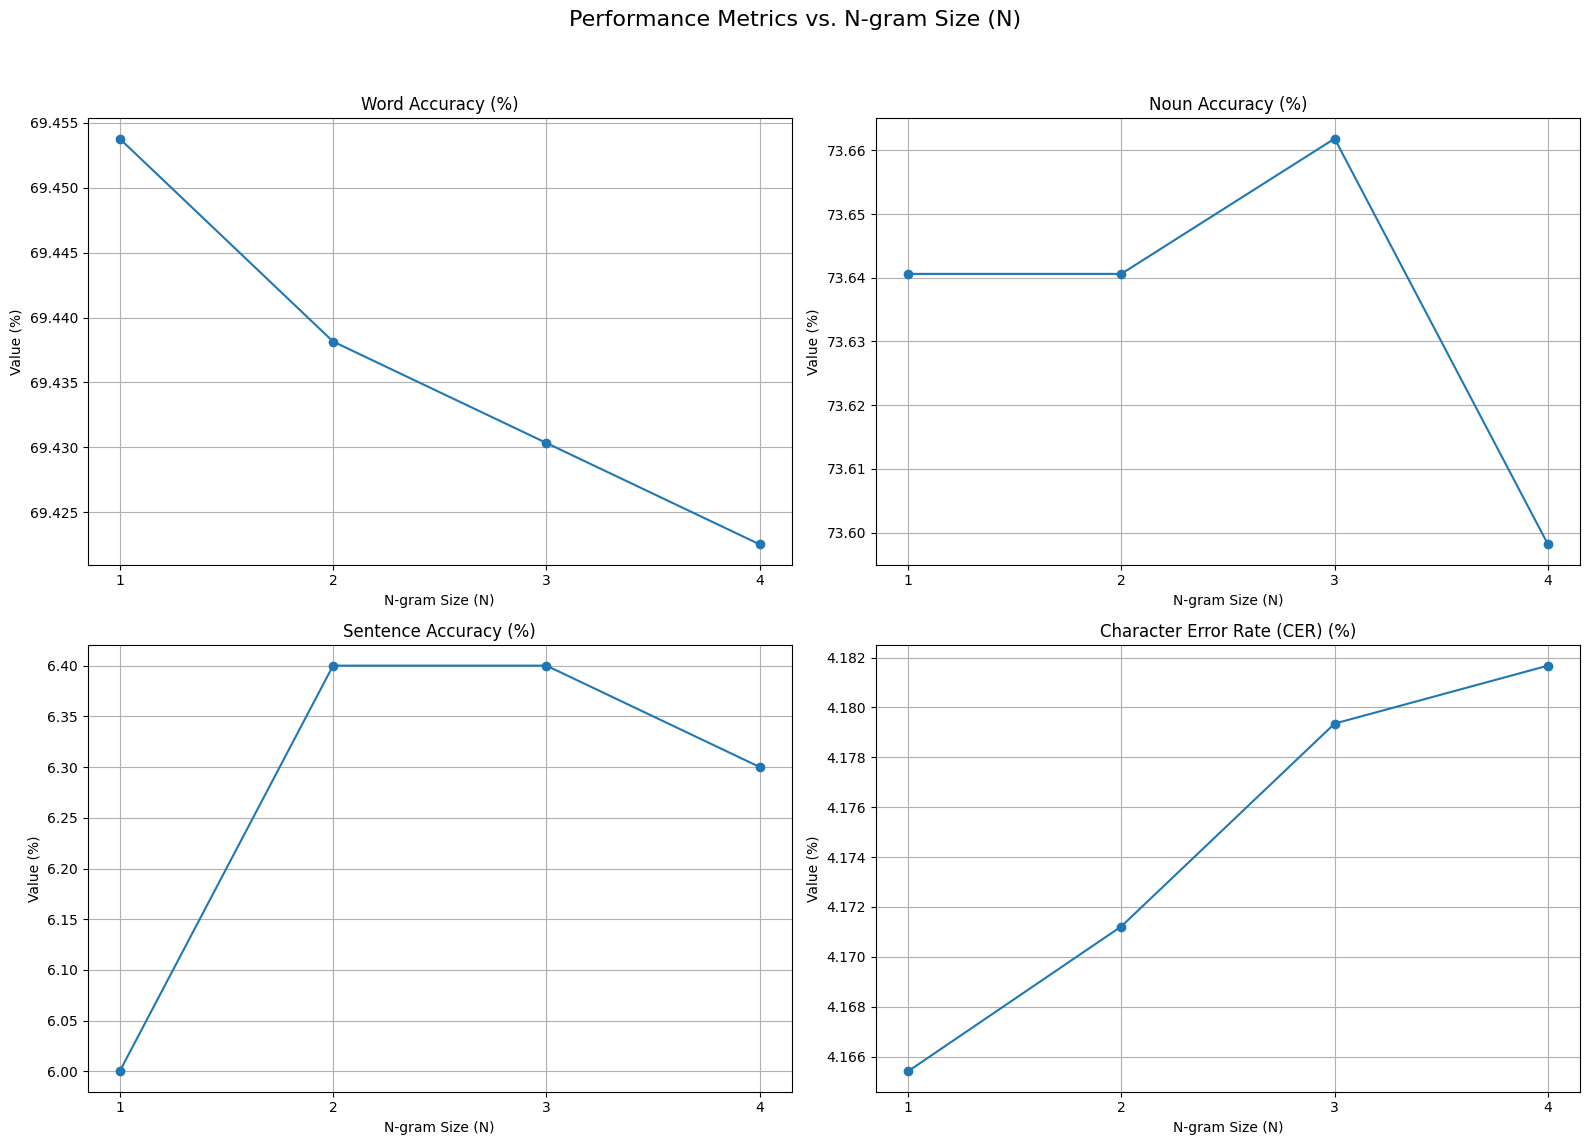

In [ ]:
import pandas as pd
import numpy as np
import ast
import spacy
from nltk.metrics.distance import edit_distance
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from nltk.util import ngrams

# --- 1. Load Data and Setup ---
print("Loading datasets and building vocabulary...")
try:
    train_df = pd.read_csv('../dataset/train.csv')
    val_df = pd.read_csv('../dataset/validation.csv')
    val_df['target_nouns'] = val_df['target_nouns'].apply(ast.literal_eval)
    val_sample_df = val_df.head(1000).copy()
    print(f"Sample of {len(val_sample_df)} rows taken from validation set.")

except FileNotFoundError:
    print("Error: Make sure 'train.csv' and 'validation.csv' are in the '../dataset/' directory.")
    val_sample_df = pd.DataFrame()

# Load spacy model
nlp = spacy.load("en_core_web_sm")

# --- 2. N-gram Model and Correction Logic ---

def build_ngram_model(series, n):
    """Builds a frequency counter for N-grams from a series of sentences."""
    print(f"Building {n}-gram model...")
    counts = Counter()
    for sentence in series:
        # Add start and end tokens for context
        tokens = ['<s>'] * (n - 1) + str(sentence).split() + ['</s>']
        # Generate N-grams
        model_ngrams = ngrams(tokens, n)
        counts.update(model_ngrams)
    return counts

def get_ngram_correction(previous_words, current_word, vocab, ngram_counts, unigram_counts, n):
    """Corrects a word based on N-gram context."""
    if current_word in vocab:
        return current_word
        
    # Generate candidates using a fixed edit distance of 2
    suggestions = [v_word for v_word in vocab if edit_distance(current_word, v_word) <= 2]
    if not suggestions:
        return current_word

    best_candidate = current_word
    max_score = -1

    # For N=1, choose the most frequent word overall
    if n == 1:
        best_candidate = max(suggestions, key=lambda word: unigram_counts.get((word,), 0))
    else:
        # For N>1, score candidates based on the preceding context
        for candidate in suggestions:
            context = tuple(previous_words + [candidate])
            score = ngram_counts.get(context, 0)
            if score > max_score:
                max_score = score
                best_candidate = candidate
                
    return best_candidate

def ngram_sentence_correction(sentence, vocab, ngram_counts, unigram_counts, n):
    """Applies N-gram based correction to an entire sentence."""
    tokens = ['<s>'] * (n - 1) + str(sentence).split()
    corrected_words = []
    
    for i in range(n - 1, len(tokens)):
        context_words = tokens[i - (n - 1) : i]
        current_word = tokens[i]
        
        corrected_word = get_ngram_correction(context_words, current_word, vocab, ngram_counts, unigram_counts, n)
        corrected_words.append(corrected_word)
        # Update token for context of the next word 
        tokens[i] = corrected_word
        
    return ' '.join(corrected_words)

# --- (Reusing Evaluation Functions from previous response) ---
def calculate_sentence_accuracy(df, true_col, pred_col):
    correct_sentences = (df[true_col] == df[pred_col]).sum()
    return (correct_sentences / len(df)) * 100
def calculate_word_accuracy(df, true_col, pred_col):
    total_words, correct_words = 0, 0
    for _, row in df.iterrows():
        true_words = str(row[true_col]).split()
        pred_words = str(row[pred_col]).split()
        total_words += len(true_words)
        for i in range(min(len(true_words), len(pred_words))):
            if true_words[i] == pred_words[i]:
                correct_words += 1
    return (correct_words / total_words) * 100 if total_words > 0 else 0
def calculate_cer(df, true_col, pred_col):
    total_distance, total_chars = 0, 0
    for _, row in df.iterrows():
        total_distance += edit_distance(str(row[true_col]), str(row[pred_col]))
        total_chars += len(str(row[true_col]))
    return (total_distance / total_chars) * 100 if total_chars > 0 else 0
def calculate_noun_accuracy(df, true_nouns_col, pred_sent_col):
    total_true_nouns, correctly_predicted_nouns = 0, 0
    for _, row in df.iterrows():
        pred_doc = nlp(str(row[pred_sent_col]))
        pred_nouns = set([token.text for token in pred_doc if token.pos_ in ('NOUN', 'PROPN')])
        correctly_predicted_nouns += len(set(row[true_nouns_col]).intersection(pred_nouns))
        total_true_nouns += len(set(row[true_nouns_col]))
    return (correctly_predicted_nouns / total_true_nouns) * 100 if total_true_nouns > 0 else 0
# ----------------------------------------------------------------

# --- 3. Run the Test Loop for N=1, 2, 3, 4 ---
results = []
ns_to_test = [1, 2, 3, 4]
all_correct_words = ' '.join(train_df['correct_cleaned_baseline'].astype(str)).split()
vocabulary = set(all_correct_words)
unigram_counts = Counter(ngrams(all_correct_words, 1))


if not val_sample_df.empty:
    for n_val in tqdm(ns_to_test, desc="Testing N-gram Models"):
        # Build the N-gram model for the current N
        ngram_model_counts = build_ngram_model(train_df['correct_cleaned_baseline'], n_val)
        
        # *** FIX IS HERE ***
        # Set the description for the upcoming progress_apply call
        tqdm.pandas(desc=f"Correcting with N={n_val}")
        
        # Generate predictions
        pred_col = f'predicted_n_{n_val}'
        val_sample_df[pred_col] = val_sample_df['incorrect_cleaned_baseline'].progress_apply(
            lambda x: ngram_sentence_correction(x, vocabulary, ngram_model_counts, unigram_counts, n_val)
        )
        
        # Calculate and store metrics
        results.append({
            'N': n_val,
            'Sentence Accuracy': calculate_sentence_accuracy(val_sample_df, 'correct_cleaned_baseline', pred_col),
            'Word Accuracy': calculate_word_accuracy(val_sample_df, 'correct_cleaned_baseline', pred_col),
            'Noun Accuracy': calculate_noun_accuracy(val_sample_df, 'target_nouns', pred_col),
            'CER': calculate_cer(val_sample_df, 'correct_cleaned_baseline', pred_col)
        })

# --- 4. Plot the Results ---
if results:
    results_df = pd.DataFrame(results)
    print("\n--- N-gram Test Results ---")
    print(results_df)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Performance Metrics vs. N-gram Size (N)', fontsize=16)
    
    metrics_to_plot = ['Word Accuracy', 'Noun Accuracy', 'Sentence Accuracy', 'CER']
    titles = ['Word Accuracy (%)', 'Noun Accuracy (%)', 'Sentence Accuracy (%)', 'Character Error Rate (CER) (%)']
    
    for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[i//2, i%2]
        ax.plot(results_df['N'], results_df[metric], marker='o')
        ax.set_title(title)
        ax.set_xlabel('N-gram Size (N)')
        ax.set_ylabel('Value (%)')
        ax.set_xticks(ns_to_test)
        ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\nCould not run tests because data was not loaded.")